# Residual U-Net Train (DCT Domain)

This notebook trains a residual U-Net model for enhanced JPEG reconstruction.

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20

In [1]:
! sudo pip install --upgrade tensorflow

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 92.5MB 711kB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 23.0MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 51.9MB/s a 0:00:01
    100% |█████

In [2]:
! pip install --upgrade pip;  pip install nibabel scikit-image

    100% |████████████████████████████████| 1.4MB 15.4MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 3.2MB 13.1MB/s ta 0:00:01
  Stored in directory: /home/ubuntu/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built bz2file


In [3]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from skimage.util import random_noise, img_as_ubyte
from tensorflow.spectral import dct, idct

from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet, my_unet
from cs_models import deep_cascade_unet_no_dc

Using TensorFlow backend.


In [4]:
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix


# ImageNet Training

In [5]:
# Train and validation data paths
images_path = "../../Gray/*.tif"
images = glob.glob(images_path)
print(len(images))
# Listing train and validation images
train_images = sorted(images[0:30000])
val_images = sorted(images[30000:45000])
test_images = sorted(images[45000:])

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))
print("Test set size:",len(test_images))

48624
Train set size: 30000
Validation set size: 15000
Test set size: 3624


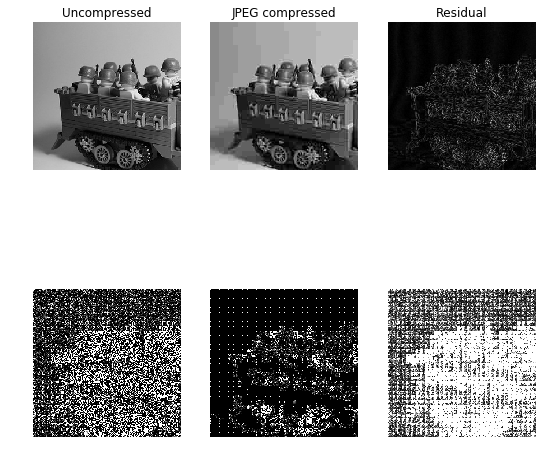

In [6]:
useblc=True

# Load uncompressed image
im1 = Image.open(train_images[500])
im1_array = np.array(im1,dtype=np.float32)

# im1_noise_array = random_noise(im1_array, mode='s&p')
# im1_noise_array = img_as_ubyte(im1_noise_array)
# im1_noise = Image.fromarray(im1_noise_array, mode='L')

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=10)
im2 = Image.open(buffer)
im2_array = np.array(im2,dtype=np.float32)

im1_array -= 128.0
im2_array -= 128.0
im1_array /= 128.0
im2_array /= 128.0

if useblc:
    dct1=dct_in_blocks(im1_array)
    dct2=dct_in_blocks(im2_array)
else:
    dct1=dct2d(im1_array)
    dct2=dct2d(im2_array)

im1_array *= 128.0
im2_array *= 128.0
im1_array += 128.0
im2_array += 128.0



# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure(figsize=(9,9))
plt.subplot(2,3,1)
plt.imshow(im1_array, cmap="gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(2,3,2)
plt.imshow(im2_array, cmap="gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.subplot(2,3,3)
plt.imshow(abs(im1_array - im2_array), cmap="gray")
plt.axis("off")
plt.title("Residual")
plt.subplot(2,3,4)
plt.imshow(dct1, cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(dct2, cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(abs(dct1 - dct2), cmap="gray", vmin=0, vmax=1/128.0)
plt.axis("off")
plt.show()

In [7]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

useNoise = False

train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)
# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    
    im1_array = np.array(im1)

    #inject noise (s&p)
    if useNoise:
        im1_array = random_noise(im1_array, mode='s&p')
        im1_array = img_as_ubyte(im1_array)
        
    train_unc[ii,:,:,0] = im1_array

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

# Centre data around 0
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [8]:
# DCT of validation set

useBlocks = True

if useBlocks:
    for ii in range(len(val_images)):
        dct_val_unc[ii,:,:,0] = dct_in_blocks(val_unc[ii,:,:,0])
        dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])    
else:
    for ii in range(len(val_images)):
        dct_val_unc[ii,:,:,0] = dct2d(val_unc[ii,:,:,0])
        dct_val_compr[ii,:,:,0] = dct2d(val_compr[ii,:,:,0])

# # DCT TRANSFORM
# for ii in range(len(train_images)):
#     dct_train_unc[ii,:,:,0] = DCT(train_unc[ii,:,:,0])
#     dct_train_compr[ii,:,:,0] = DCT(train_compr[ii,:,:,0])
#     #dct_train_unc[ii,:,:,0] = DCT(train_unc[ii,:,:,0], norm='ortho')
    
# for ii in range(len(val_images)):
#     dct_val_unc[ii,:,:,0] = DCT(val_unc[ii,:,:,0])
#     dct_val_compr[ii,:,:,0] = DCT(val_compr[ii,:,:,0])
# #     dct_val_unc[ii,:,:,0] = DCT(val_unc[ii,:,:,0], norm='ortho')
# #     dct_val_compr[ii,:,:,0] = DCT(val_compr[ii,:,:,0], norm='ortho')

In [9]:
# normalize
# dct_train_unc = (dct_train_unc - np.min(dct_train_unc)) / (np.max(dct_train_unc) - np.min(dct_train_unc))
# dct_train_compr = (dct_train_compr - np.min(dct_train_compr)) / (np.max(dct_train_compr) - np.min(dct_train_compr))
# dct_val_unc = (dct_val_unc - np.min(dct_val_unc)) / (np.max(dct_val_unc) - np.min(dct_val_unc))
# dct_val_compr = (dct_val_compr - np.min(dct_val_compr)) / (np.max(dct_val_compr) - np.min(dct_val_compr))

print(np.min(dct_val_unc), np.max(dct_val_unc))
print(np.min(dct_val_compr), np.max(dct_val_compr))

-7.9999995 7.9374995
-7.9999995 7.9374995


Validation set


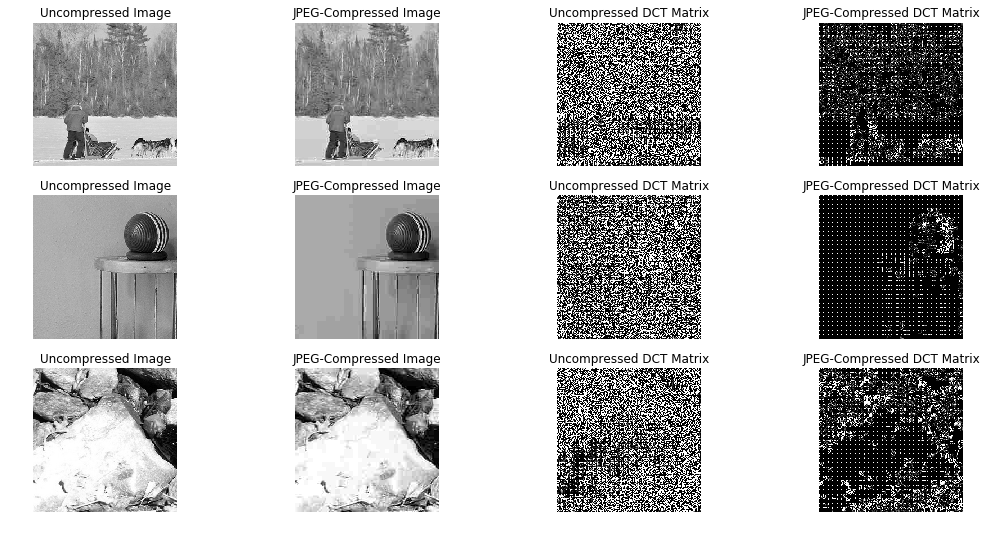

In [10]:
indexes_val = np.arange(len(val_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Validation set")
plt.figure(figsize = (18,9))
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(val_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(val_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(dct_val_unc[indexes_val[ii],:,:,0],cmap = "gray",vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.title("Uncompressed DCT Matrix")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(dct_val_compr[indexes_val[ii],:,:,0],cmap = "gray",vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.title("JPEG-Compressed DCT Matrix")
plt.show()    


In [11]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_pydct_data_augmentation_compress_10_20-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


# opt = Adam(lr=0.0001)
# model = unet(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
# model.compile(loss = "mse",optimizer=opt)

opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

# Use pre-train network
#model.load_weights("../Models/residual_unet_data_augmentation_imagenet_compress_16_20.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block
1 i
Append U-net block


In [12]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()
        
        if compr_range[0] != compr_range[1]:
            compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)
        else:
            compr = np.zeros(batch_unc.shape[0]) + compr_range[0] # note: compr is a float

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
#             dct_batch_unc[ii,:,:,0] = DCT(batch_unc[ii,:,:,0]/255.0)
#             dct_batch_comp[ii,:,:,0] = DCT(batch_comp[ii,:,:,0]/255.0)
            
            if useBlocks:
                dct_batch_unc[ii,:,:,0] = dct_in_blocks((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
                dct_batch_comp[ii,:,:,0] = dct_in_blocks((batch_comp[ii,:,:,0]-128.0)/128.0)
            else:
                dct_batch_unc[ii,:,:,0] = dct2d((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
                dct_batch_comp[ii,:,:,0] = dct2d((batch_comp[ii,:,:,0]-128.0)/128.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-7.8749995 7.9374995
-7.962426 7.9374995


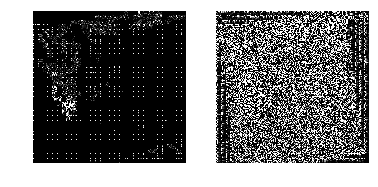

In [13]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.show()
    break

In [14]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3750/3750 [==============================] - 1456s 388ms/step - loss: 0.0038 - val_loss: 0.0068
Epoch 2/30
3750/3750 [==============================] - 1412s 377ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 3/30
3750/3750 [==============================] - 1418s 378ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 4/30
3750/3750 [==============================] - 1413s 377ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 5/30
3750/3750 [==============================] - 1417s 378ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 6/30
3750/3750 [==============================] - 1412s 377ms/step - loss: 0.0033 - val_loss: 0.0064
Epoch 7/30
3750/3750 [==============================] - 1420s 379ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 8/30
3750/3750 [==============================] - 1412s 377ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 9/30
3750/3750 [==============================] - 1418s 378ms/step - loss: 0.0032 - val_lo

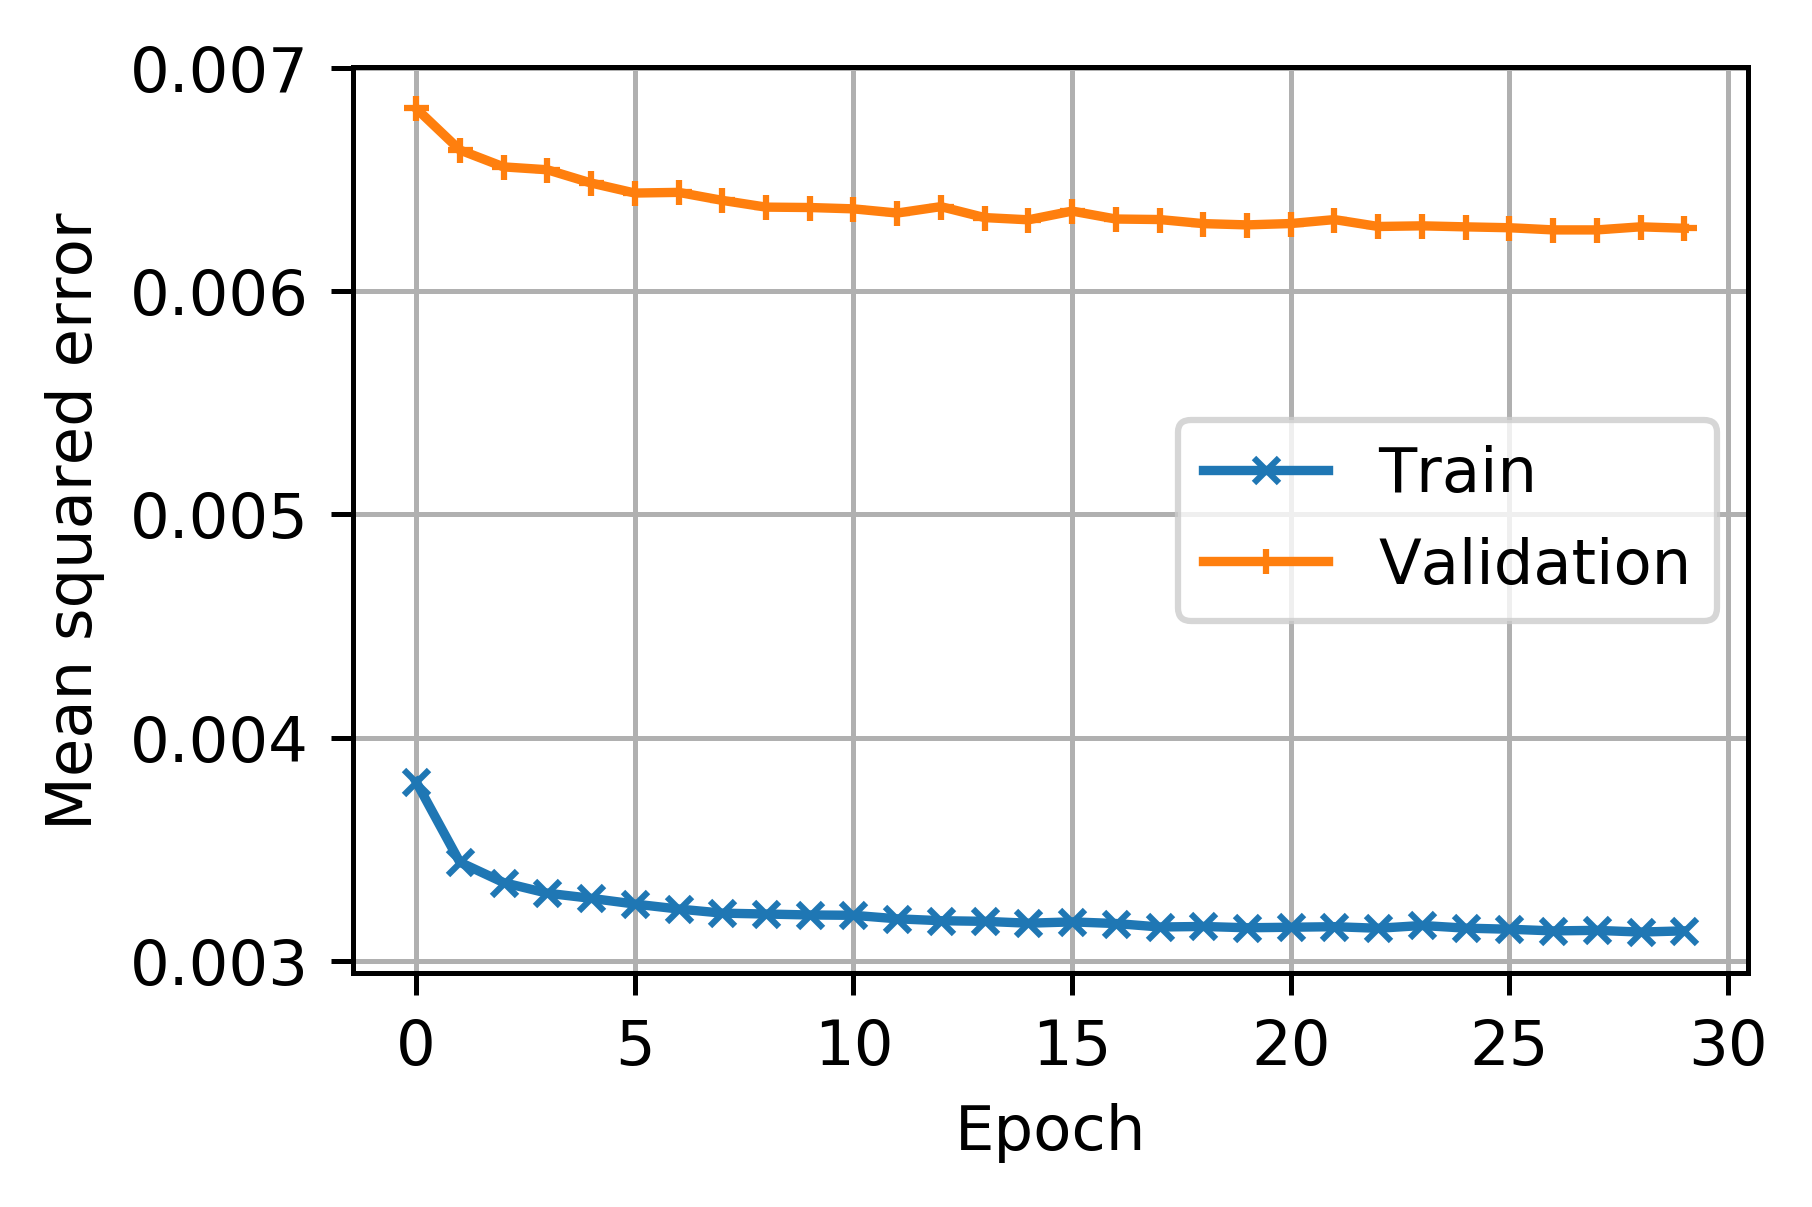

In [15]:
#Saving training history
np.save("../Data/loss_residual_wnet_pydct_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_pydct_data_augmentation_compress_10_20-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()